In [327]:
import matplotlib.pyplot as plt
import pylab
import math
import numpy as np
import scipy
import cmath
from scipy import special
from scipy import integrate
from numpy.polynomial.hermite import hermval

In [432]:
num_points = 4000
n= 30
n_max_gs =50
n_max_ex =50

#hartree energy unit
D_gs = 0.475217 #2.071824545e-18 J
D_ex = 0.20149  #8.78444853e-19 J

#bohr^-1 units
alpha_gs = 1.17199002 #6.20190409869e-11 meters^-1
alpha_ex = 1.23719524 #6.54695526318e-11 meters^-1

#bohr units'
shift_ex = 0.201444790427

#mass in a.u.
mu = 12178.1624678

In [433]:
def spring_const(alpha,D):
	return (alpha**2)*2*D

def mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu):
	omega_gs = np.sqrt(spring_const(alpha_gs,D_gs)/mu)/2*math.pi
	omega_ex = np.sqrt(spring_const(alpha_ex,D_ex)/mu)/2*math.pi
	return omega_gs,omega_ex

def compute_Harm_eval_n(omega,D,n):
	return omega*(n+0.5)-(omega**2/(4.0*D)*(n+0.5)**2.0)

def find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift):
	freq_gs = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[0]
	freq_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]
	E_max_gs=compute_Harm_eval_n(freq_gs,D_gs,n_max_gs) # compute the energies for the highest energy morse 
	E_max_ex=compute_Harm_eval_n(freq_ex,D_ex,n_max_ex) # state considered
	# find the two classical turning points for the ground state PES
	point1_gs = math.sqrt(2*E_max_gs/spring_const(alpha_gs,D_gs))
	point2_gs = -math.sqrt(2*E_max_gs/spring_const(alpha_gs,D_gs))
	
	point1_ex = math.sqrt(2*E_max_ex/spring_const(alpha_ex,D_ex))+shift
	point2_ex = -math.sqrt(2*E_max_ex/spring_const(alpha_ex,D_ex))+shift

	# now find the smallest value and the largest value
	start_point=min(point1_gs,point2_gs)
	end_point=max(point1_ex,point2_ex)
	return start_point,end_point



In [434]:
start_point=find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift_ex)[0]
end_point=find_classical_turning_points_morse(n_max_gs,n_max_ex,alpha_gs,alpha_ex,D_gs,D_ex,shift_ex)[1]

#mode frequency of each oscillator
omega_gs = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[0]
omega_ex = mode_freq(alpha_gs,D_gs,alpha_ex,D_ex,mu)[1]

#quantum turning points, established from 10% increase of classical tp's due to tunneling
start_point=start_point-start_point*0.1
end_point= end_point+end_point*0.1
step_x=(end_point-start_point)/num_points
x_range = np.arange(start_point,end_point,step_x)

In [435]:
def Harm_wavefunc(x_range,omega,mu,n,shift):
	wavefunc=((num_points,2))
	r_val=x_range*(math.sqrt(mu*omega))
	r_shift_val=shift*(math.sqrt(mu*omega))
	herm_coeffs = np.zeros(n+1)
	herm_coeffs[n] = 1
	norm=1/math.sqrt((2**n)*math.factorial(n))*(mu*omega/math.pi)**(0.25)
	#renormalize to prevent error buildup
	psi_unormed = norm*np.exp(-((r_val-r_shift_val)**2)/2)*np.polynomial.hermite.hermval(r_val-r_shift_val,herm_coeffs)
	psi_norm = integrate.simps(psi_unormed**2,dx=step_x)
	psi = psi_unormed/math.sqrt(psi_norm)
	
	return psi

In [436]:

def Morse_wavefunc(num_points,start_point,end_point,D,alpha,mu,n,shift):
        # first start by filling array with position points:
        wavefunc=np.zeros((num_points,2))
        lamda=math.sqrt(2.0*D*mu)/(alpha)
        step_x=(end_point-start_point)/num_points
        denom=special.gamma(2.0*lamda-n)
        if np.isinf(denom):
                denom=10e280
        num=(math.factorial(n)*(2.0*lamda-2.0*n-1.0))
        normalization=math.sqrt(num/denom)
        counter=0
        for x in wavefunc:
                x[0]=start_point+counter*step_x
                r_val=(start_point+counter*step_x)*alpha
                r_shift_val=(shift)*alpha
                z_val=2.0*lamda*math.exp(-(r_val-r_shift_val))
                func_val=normalization*z_val**(lamda-n-0.5)*math.exp(-0.5*z_val)*special.assoc_laguerre(z_val,n,2.0*lamda-2.0*n-1.0)
                x[1]=func_val
                counter=counter+1

	# fix normalization regardless of value of denominator to avoid rounding errors
        wavefunc_sq=np.zeros(wavefunc.shape[0])
        wavefunc_sq[:]=wavefunc[:,1]*wavefunc[:,1]
        normalization=integrate.simps(wavefunc_sq,dx=step_x)
        for counter in range(wavefunc.shape[0]):
                wavefunc[counter,1]=wavefunc[counter,1]/math.sqrt(normalization)

        return wavefunc

**LC_coefficients function**

The LC_coefficients function below has two return outputs. The squared coefficcients are used as a failsafe to determine if your overlaps are caculated correctly. For any given function you are building with an LC of harmonic oscillators, the sum of their squared coefficients should approach 1 with increasing coeffs. For calculationsinvovling summing the coefficients you must use the "unsquared" list of coeffs.

In [437]:
def LC_coefficients(x_range,omega_gs,omega_ex,num_points,start_point,end_point,D_gs,alpha_gs,mu,n,shift):
    morse = Morse_wavefunc(num_points,start_point,end_point,D_gs,alpha_gs,mu,10,0.0)
    LC_coeffs = np.zeros(n+1)
    for i in range(n+1):
        LC_coeffs[i] = integrate.simps(morse[:,1]*Harm_wavefunc(x_range,omega_gs,mu,i,0),x_range,dx=step_x)
    return LC_coeffs,LC_coeffs**2

In [438]:
coefficients = LC_coefficients(x_range,omega_gs,omega_ex,num_points,start_point,end_point,D_gs,alpha_gs,mu,n,shift_ex)
print('coefficients sum SQ:',sum(coefficients[1]))

#sum of your squared overlap coefficients should approach convergence to 1 with increase in total states

coefficients sum SQ: 0.9857869054195477


In [429]:
def Linear_combo_wfs(x_range,omega_gs,omega_ex,mu,n,shift):
	coefficients=LC_coefficients(x_range,omega_gs,omega_ex,num_points,start_point,end_point,D_gs,alpha_gs,mu,n,shift)[0]
	LC_func = np.zeros((num_points,n+1))
	for i in range (n+1):
		LC_func[:,i]=Harm_wavefunc(x_range,omega_gs,mu,i,0)*coefficients[i]
	#print(LC_func)
	return LC_func.sum(axis=1)

In [430]:
Morse_from_LC_of_Harm_osc_10n=Linear_combo_wfs(x_range,omega_gs,omega_ex,mu,10,shift_ex)
# print('Morse_from_LC_of_Harm_osc:',Morse_from_LC_of_Harm_osc)
Morse_from_LC_of_Harm_osc_11n=Linear_combo_wfs(x_range,omega_gs,omega_ex,mu,11,shift_ex)
Morse_from_LC_of_Harm_osc_30n=Linear_combo_wfs(x_range,omega_gs,omega_ex,mu,30,shift_ex)
Morse_from_LC_of_Harm_osc_40n=Linear_combo_wfs(x_range,omega_gs,omega_ex,mu,40,shift_ex)

In [431]:
Morse_gs_v0 = Morse_wavefunc(num_points,start_point,end_point,D_gs,alpha_gs,mu,10,0)

In [425]:
Harmonic_v0 = Harm_wavefunc(x_range,omega_gs,mu,10,0)

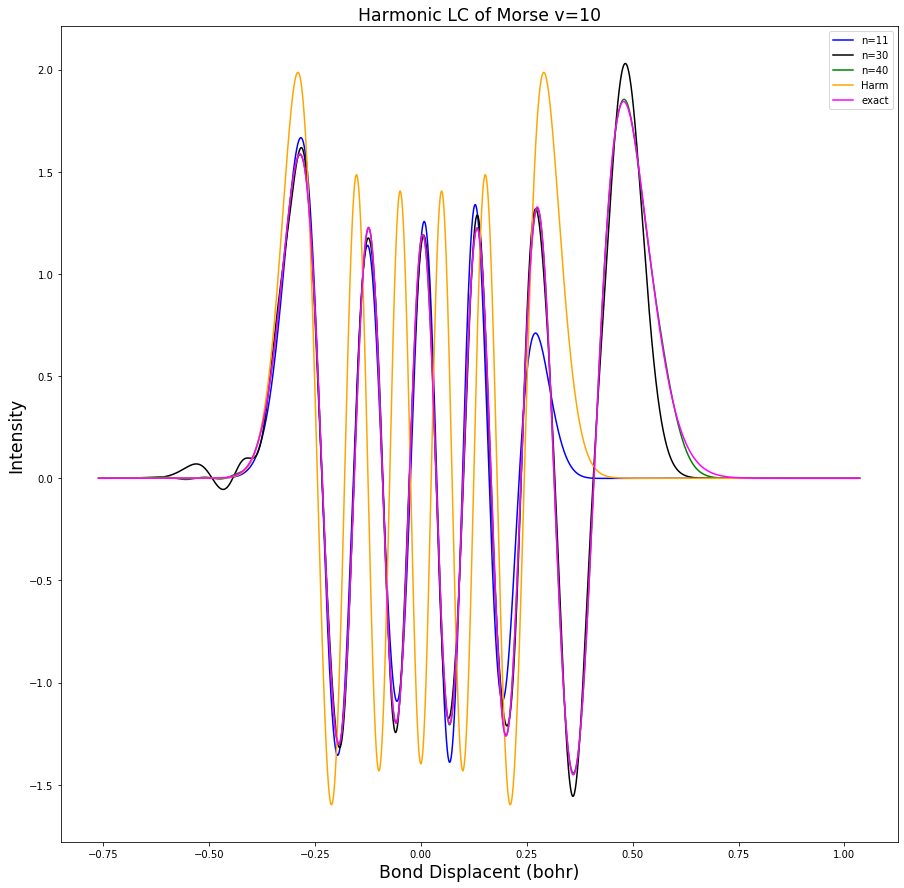

In [426]:
x = x_range
y6 = Morse_gs_v0[:,1]
# y2 = Morse_from_LC_of_Harm_osc[:]
y5 = Harmonic_v0[:]


y1 = Morse_from_LC_of_Harm_osc_10n
y2 = Morse_from_LC_of_Harm_osc_11n
y3 = Morse_from_LC_of_Harm_osc_30n
y4 = Morse_from_LC_of_Harm_osc_40n


fig,ax = plt.subplots(figsize=(15,15))

# line1 = ax.plot(x,y1,color='red',label='n=10')
line2 = ax.plot(x,y2,color='blue',label='n=11')
line3 = ax.plot(x,y3,color='black',label='n=30')
line4 = ax.plot(x,y4,color='green',label='n=40')
line5 = ax.plot(x,y5,color='orange',label='Harm')
line5 = ax.plot(x,y6,color='magenta',label='exact')

# plt.plot(Morse_gs_v0[:,1],color='red',label='Morse')
# plt.plot(Morse_from_LC_of_Harm_osc,color='blue',label='Morse_LC')
plt.title('Harmonic LC of Morse v=10',fontsize='xx-large')
ax.set_xlabel('Bond Displacent (bohr)',fontsize='xx-large')
ax.set_ylabel('Intensity',fontsize='xx-large')

ax.legend()
plt.show()
